# Classification. Linear models and KNN

In [535]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [536]:
# ADDITIONAL STYLING & UTILITIES FOR THIS NOTEBOOK
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

In [537]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [538]:
from sklearn.exceptions import NotFittedError

In [539]:
def sig_helper(x):
    return 1 / (1 + np.exp(-x))

def norm_helper(x, order):
    return np.sum(np.abs(x) ** order) ** (1 / order) 

class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init

    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return sig_helper(X @ weights)
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return np.mean(np.log(1 + np.exp(- (x @ weights) * y))) + norm_helper(weights, 2) / 2 / self.C
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        losses = []

        for i in range(self.max_iter):
            delta = self.weights_ / self.C - np.mean(y * X_ext.T * (1 - sig_helper((X_ext @ self.weights_) * y)), axis=1)
            self.weights_ -= self.eta * delta

            loss = self.get_loss(X_ext, self.weights_, y)
            losses.append(loss)

            if norm_helper(self.eta * delta, 2) < self.tol:
                break
                
        self.losses_ = np.array(losses)
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return (self.predict_proba(X) > 0.5) * 2 - 1

In [540]:
from sklearn import datasets
from sklearn import metrics

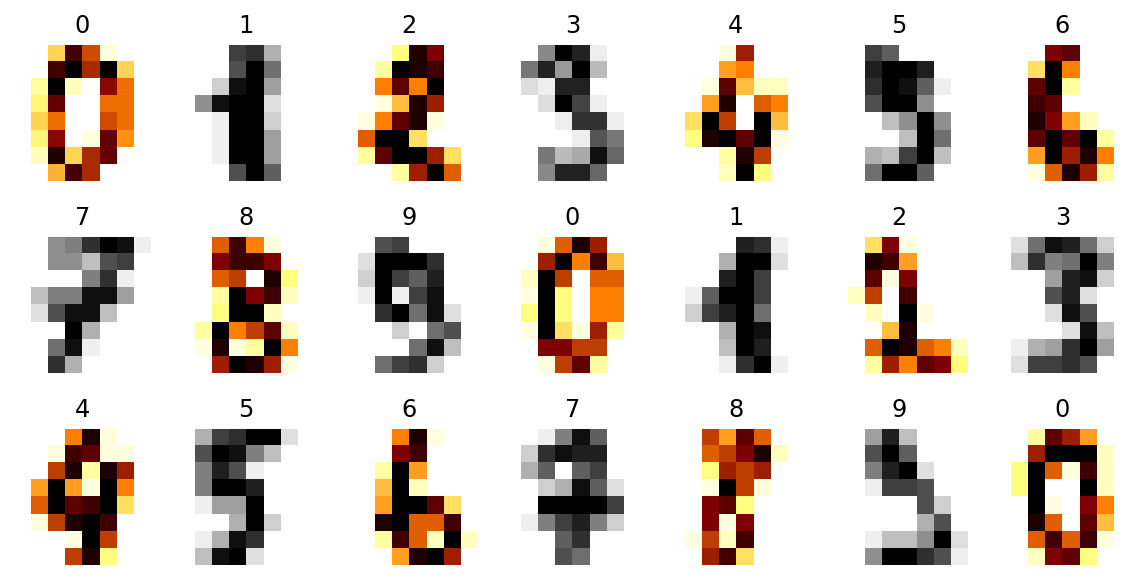

In [541]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [542]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [543]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [544]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [545]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [546]:
lr_clf.fit(X_train, y_train)

In [547]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [548]:
model = CustomLogisticRegression()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


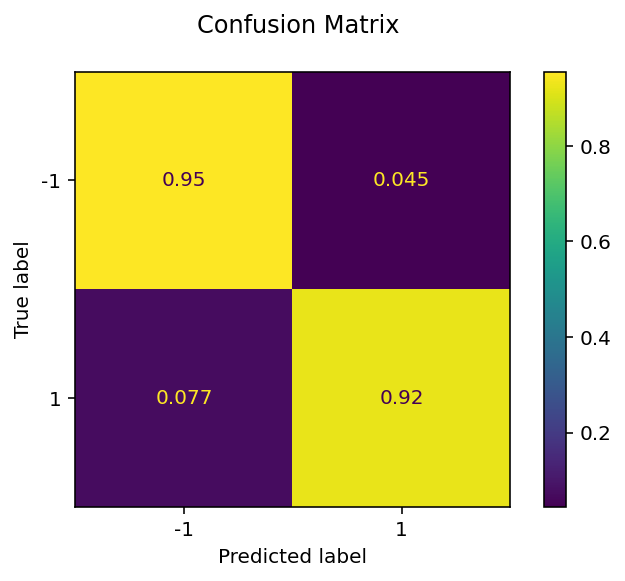

In [549]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [550]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [551]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

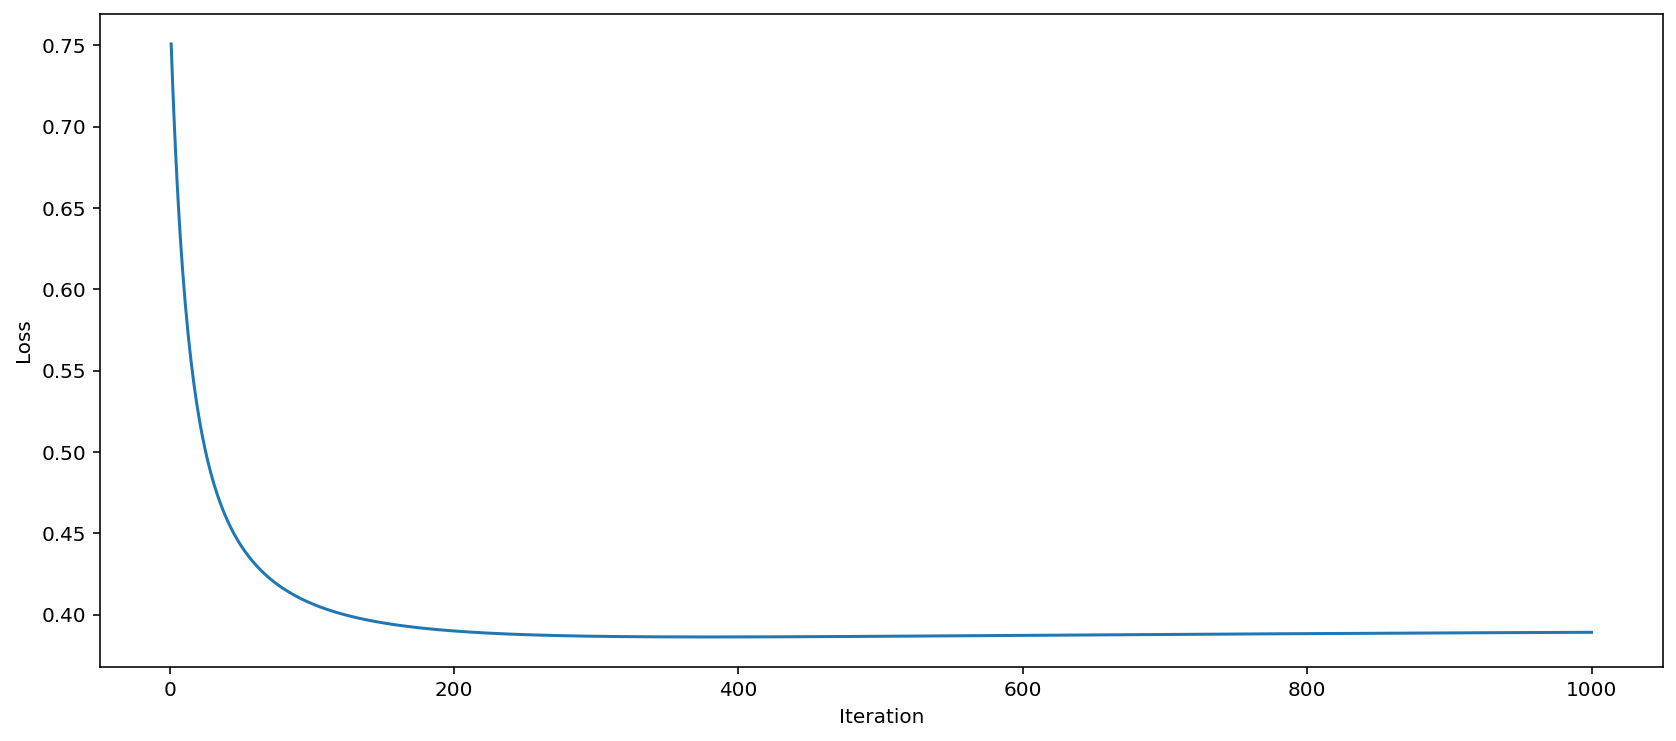

In [552]:
plt.figure(figsize=(14,6))
plt.ylabel('Loss')
plt.xlabel('Iteration')

sns.lineplot(y=model.losses_, x=range(1,1001));

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

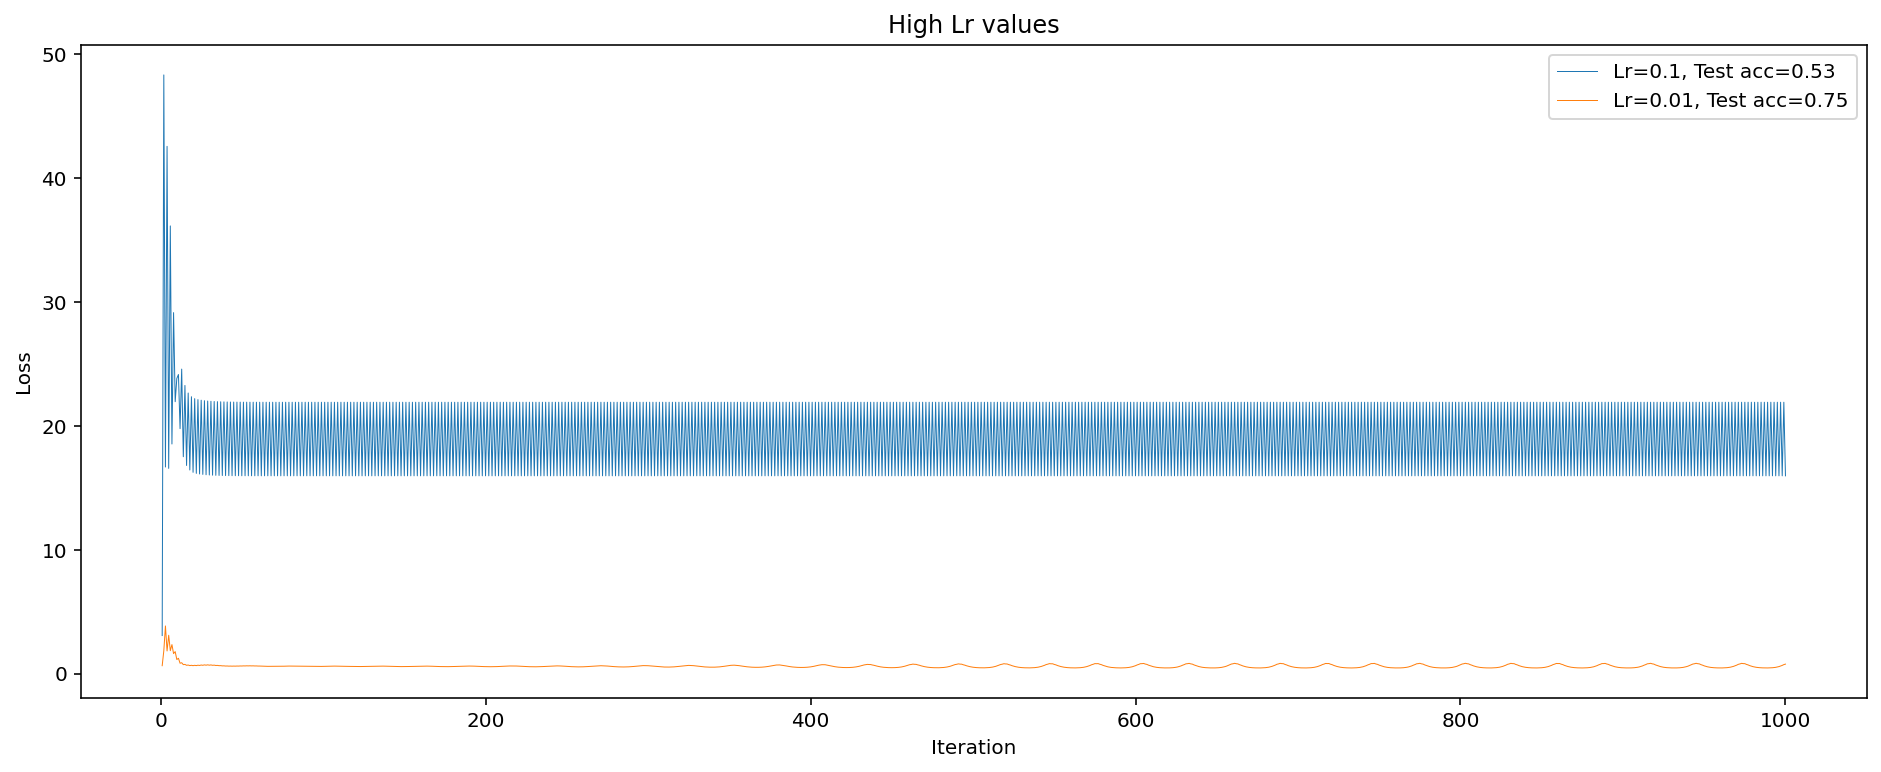

In [553]:
plt.figure(figsize=(16,6))
plt.ylabel('Loss')
plt.xlabel('Iteration')

for lr in [10**-power for power in range(1, 3)]:
    model = CustomLogisticRegression(eta=lr)
    model.fit(X_train, y_train)
    accuracy = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    sns.lineplot(y=model.losses_, x=range(1,len(model.losses_)+1), label=f"Lr={lr}, Test acc={accuracy:.2f}", linewidth=0.5).set_title('High Lr values');

Model with Lr=0.001 finished learning after 2000 iterations with test acc=0.94
Model with Lr=0.0001 finished learning after 3000 iterations with test acc=0.91
Model with Lr=1e-05 finished learning after 3000 iterations with test acc=0.88
Model with Lr=1e-06 finished learning after 1 iterations with test acc=0.28


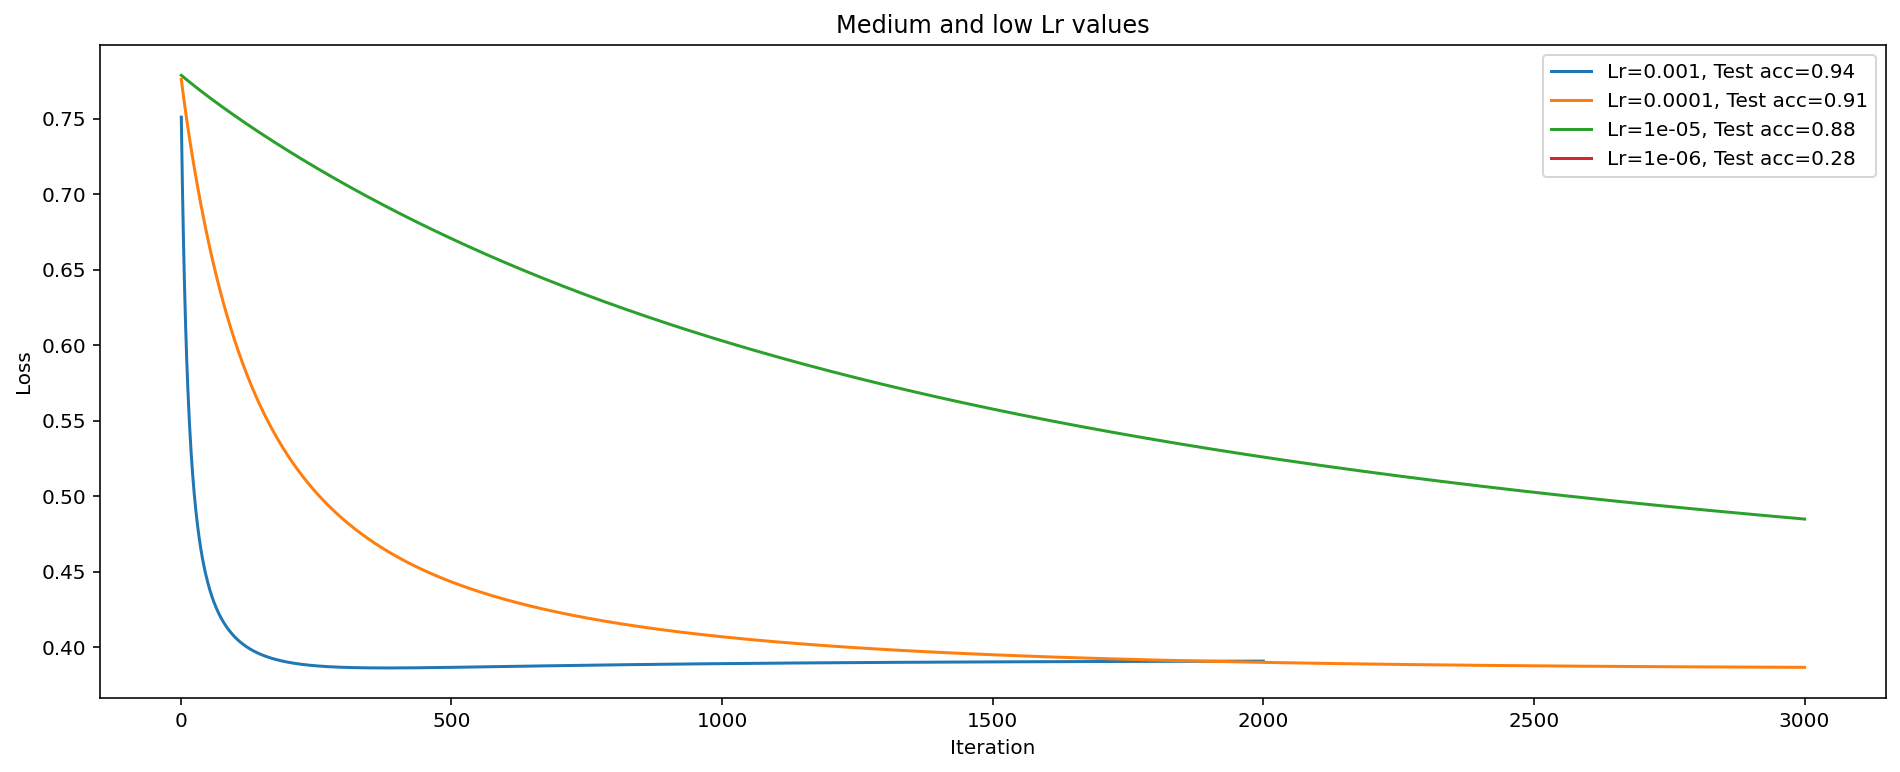

In [554]:
plt.figure(figsize=(16,6))
plt.ylabel('Loss')
plt.xlabel('Iteration')

for lr in [10**-power for power in range(3, 7)]:
    model = CustomLogisticRegression(eta=lr, max_iter=3000)
    model.fit(X_train, y_train)
    accuracy = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    iterations = len(model.losses_)
    sns.lineplot(y=model.losses_, x=range(1,iterations+1), label=f"Lr={lr}, Test acc={accuracy:.2f}").set_title('Medium and low Lr values');
    print(f"Model with Lr={lr} finished learning after {iterations} iterations with test acc={accuracy:.2f}")

> It seems that when `learning rate` quite high we can't stabilize the model and it can't be optimized due to the fact, that we can't go down to the minumum. On the other hand if the `learning rate` will be low, then optimization speed will be low and it will require lots of iterations to optimize. If the value will be super-low - it will think that the model was stabilized even before full optimization and therefore with low accuracy. 

> Sweet spot - medium values, e.g. `Lr=0.001` will be able to reach good values at ~300 iterations with even better results for 1000 iterations. 

![image.png](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

**(0.5 points)** Try different regularization parameter values and compare the model quality.

Model with C=0.05 finished learning after 208 iterations with test acc=0.90
Model with C=0.55 finished learning after 1280 iterations with test acc=0.93
Model with C=1.05 finished learning after 2073 iterations with test acc=0.94
Model with C=1.55 finished learning after 2747 iterations with test acc=0.94
Model with C=2.05 finished learning after 3000 iterations with test acc=0.94
Model with C=2.55 finished learning after 3000 iterations with test acc=0.94
Model with C=3.05 finished learning after 3000 iterations with test acc=0.94
Model with C=3.55 finished learning after 3000 iterations with test acc=0.94
Model with C=4.05 finished learning after 3000 iterations with test acc=0.94
Model with C=4.55 finished learning after 3000 iterations with test acc=0.94
Model with C=5.05 finished learning after 3000 iterations with test acc=0.94


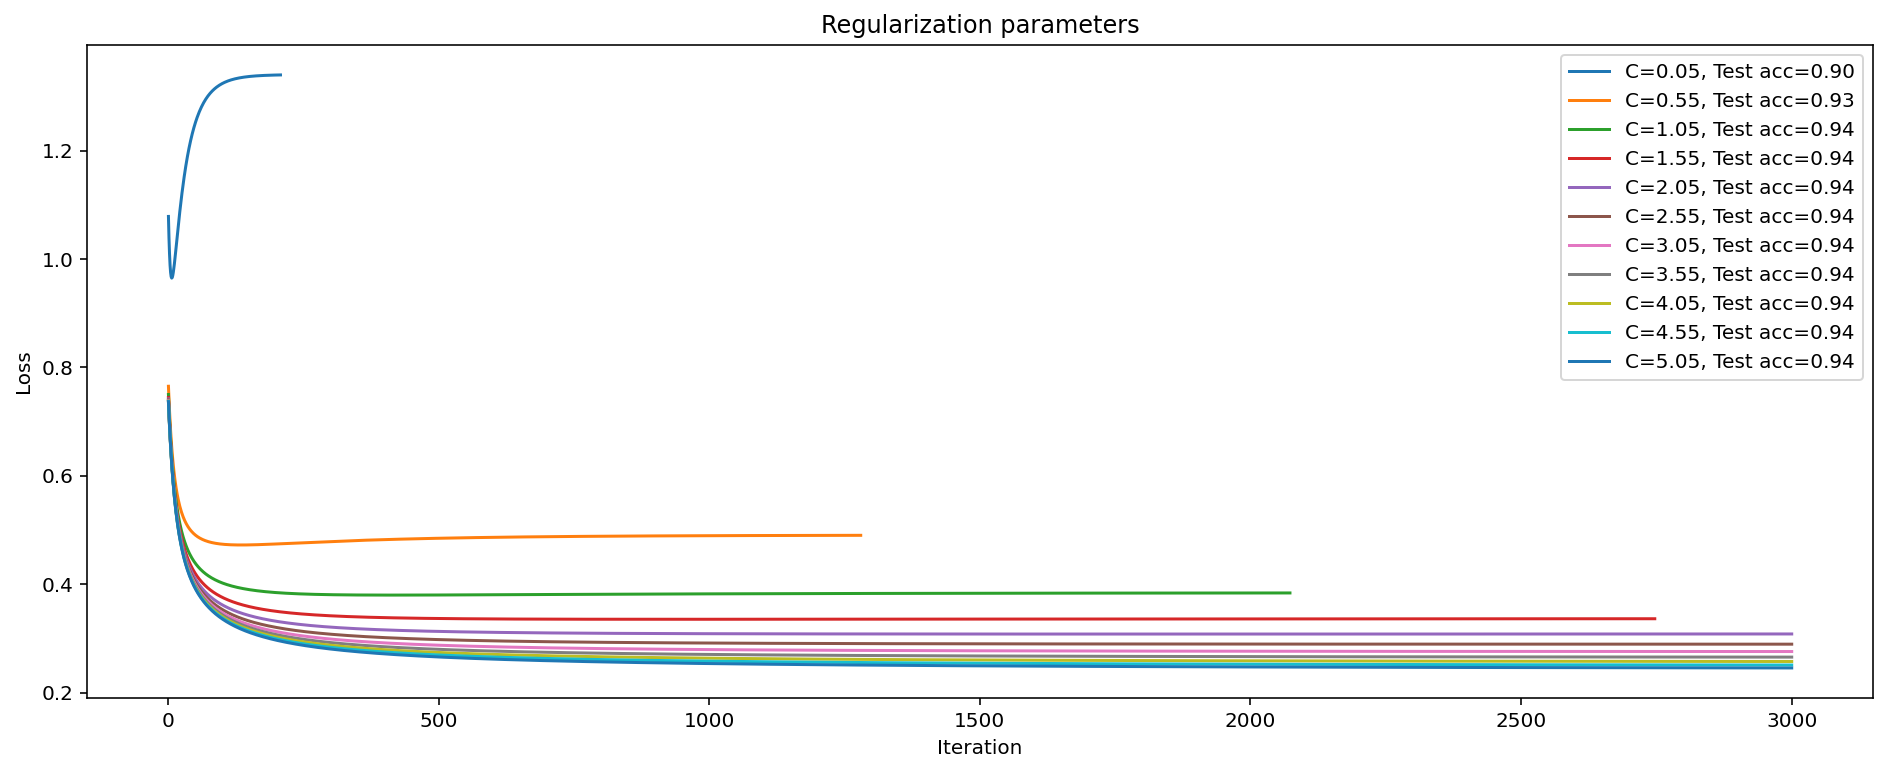

In [555]:
plt.figure(figsize=(16,6))
plt.ylabel('Loss')
plt.xlabel('Iteration')

for c in np.linspace(0.05, 5.05, 11):
    model = CustomLogisticRegression(C=c, max_iter=3000)
    model.fit(X_train, y_train)
    accuracy = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    iterations = len(model.losses_)
    sns.lineplot(y=model.losses_, x=range(1,iterations+1), label=f"C={c}, Test acc={accuracy:.2f}").set_title('Regularization parameters');
    print(f"Model with C={c} finished learning after {iterations} iterations with test acc={accuracy:.2f}")

> Regularization works well on higher values, in our case the lower value (high regularization) the faster model will be able to stabilize, but if the value will be too low - the model will not be able to stabilize. If the value relatively medium `~0.5-1` it will introduce higher loss on train data, but low penalty on accuracy and faster stabilization.  

**(0.5 points)** Compare zero initialization and random initialization. 

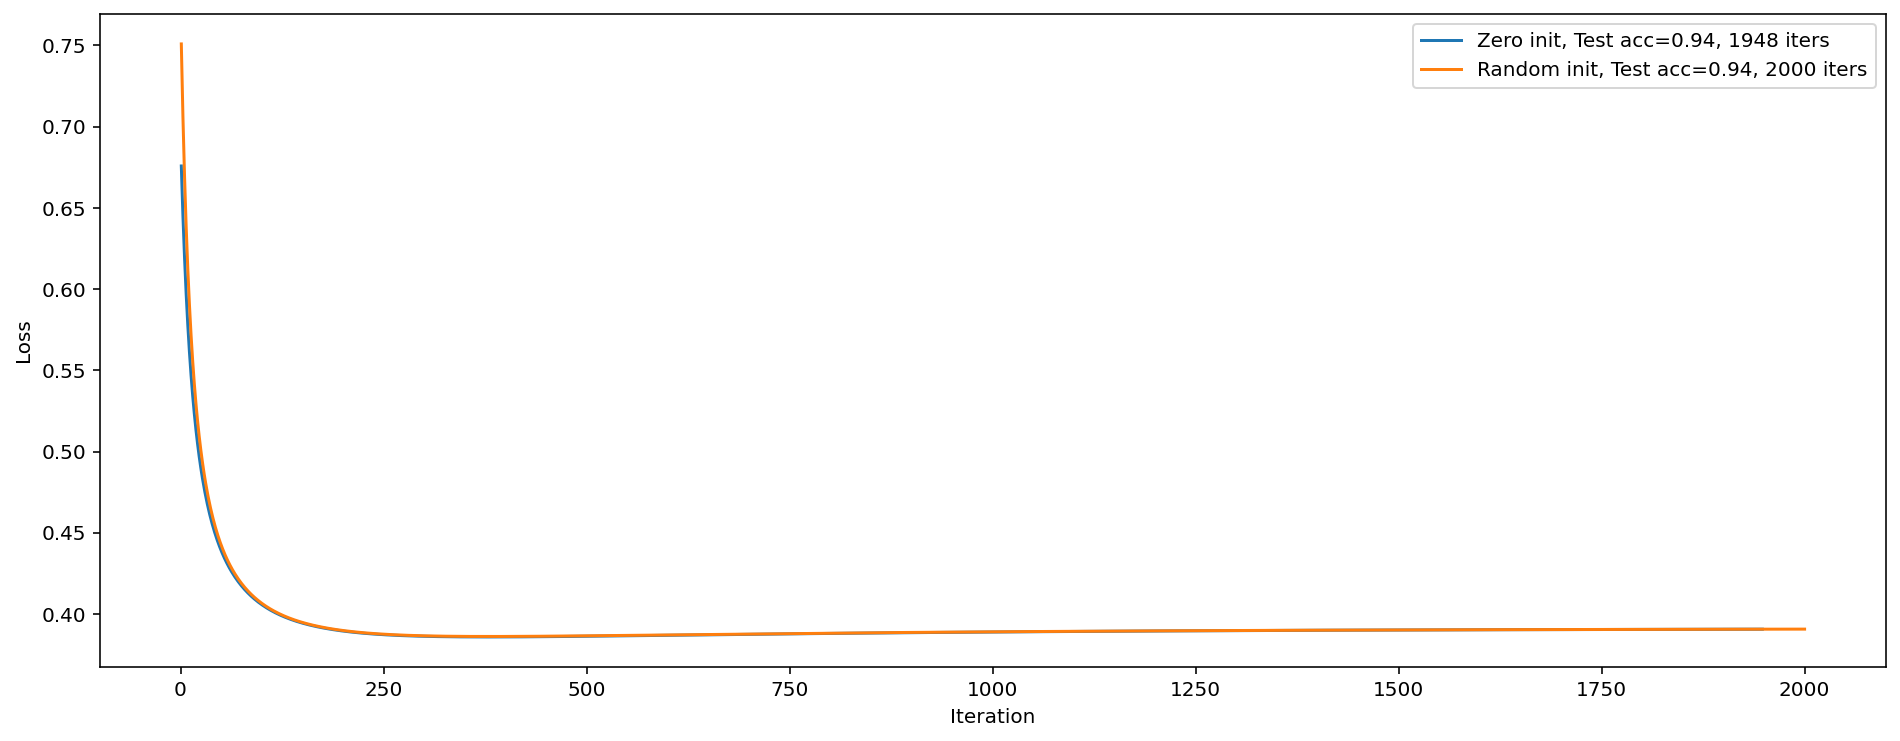

In [556]:
plt.figure(figsize=(16,6))
plt.ylabel('Loss')
plt.xlabel('Iteration')

model_zero = CustomLogisticRegression(zero_init=True, max_iter=3000)
model_zero.fit(X_train, y_train)
accuracy_zero = metrics.accuracy_score(y_pred=model_zero.predict(X_test), y_true=y_test)
iters_zero = len(model_zero.losses_)
sns.lineplot(y=model_zero.losses_, x=range(1,iters_zero+1), label=f"Zero init, Test acc={accuracy:.2f}, {iters_zero} iters")

model_random = CustomLogisticRegression(max_iter=3000)
model_random.fit(X_train, y_train)
accuracy_random = metrics.accuracy_score(y_pred=model_random.predict(X_test), y_true=y_test)
iters_random = len(model_random.losses_)
sns.lineplot(y=model_random.losses_, x=range(1,iters_random+1), label=f"Random init, Test acc={accuracy:.2f}, {iters_random} iters");

> Almost no difference between two models, but the variant with zero init is getting lower loss at the start. 

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [557]:
def mesh_helper(grid, data):
    return data[grid]

class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        XX, YY = np.meshgrid(range(0, X.shape[0]), range(0, Y.shape[0]), indexing='ij')

        return np.sum((mesh_helper(XX, X) - mesh_helper(YY, Y)) ** 2, axis=2) ** 0.5
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """

        idx = np.zeros(y.shape[0], dtype='int64')
        for i in range(len(self.classes_)):
            idx += np.where(y==self.classes_[i], i, 0)

        return np.bincount(idx, weights=weights)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)

            y_ids = np.arange(0, P.shape[1])
            nearest_ids = P.argsort(axis=-1)[:, :self.n_neighbors]
            
            mask_nn = (y_ids == nearest_ids[...,None]).any(axis=1)        
            
            nn_weights = weights_of_points * mask_nn
            class_weights = np.apply_along_axis(lambda row: self.get_class_weights(self.y, row), -1, nn_weights)

            return class_weights / np.sum(class_weights, axis=-1)[..., None]
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """

        best_class = self.predict_proba(X).argmax(axis=1)

        return self.classes_[best_class]

In [558]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [559]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [560]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

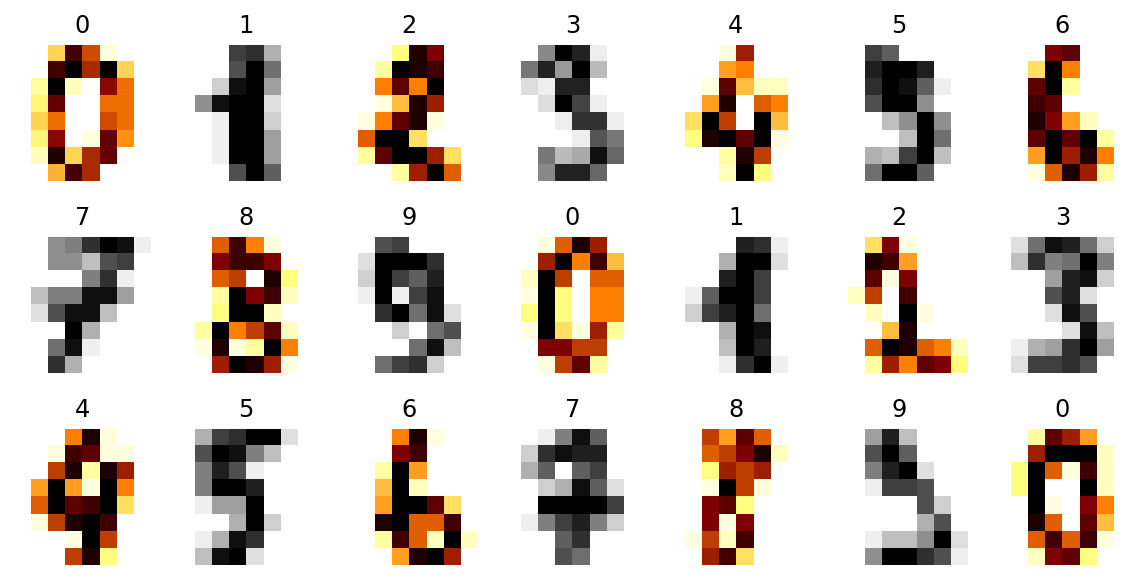

In [561]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [562]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [563]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


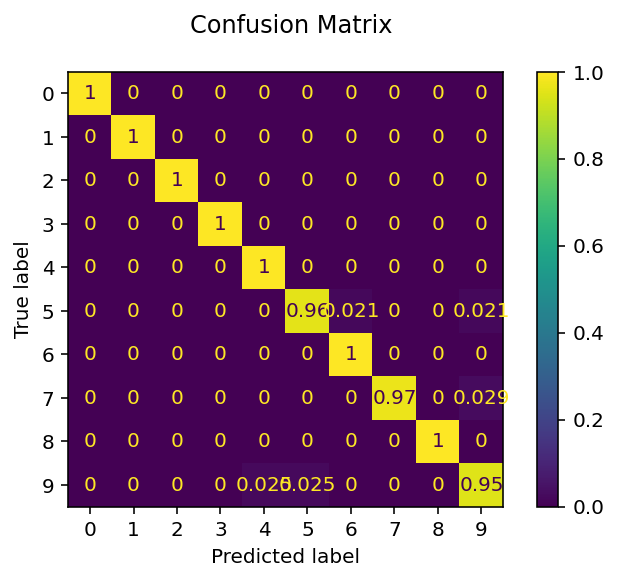

In [564]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [565]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

> The shape of `4` `5` and `9` can be easily confused since they share common features and therefore the spaces of answers intersect each other. Therefore `kNN` founds not just one class in the area.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

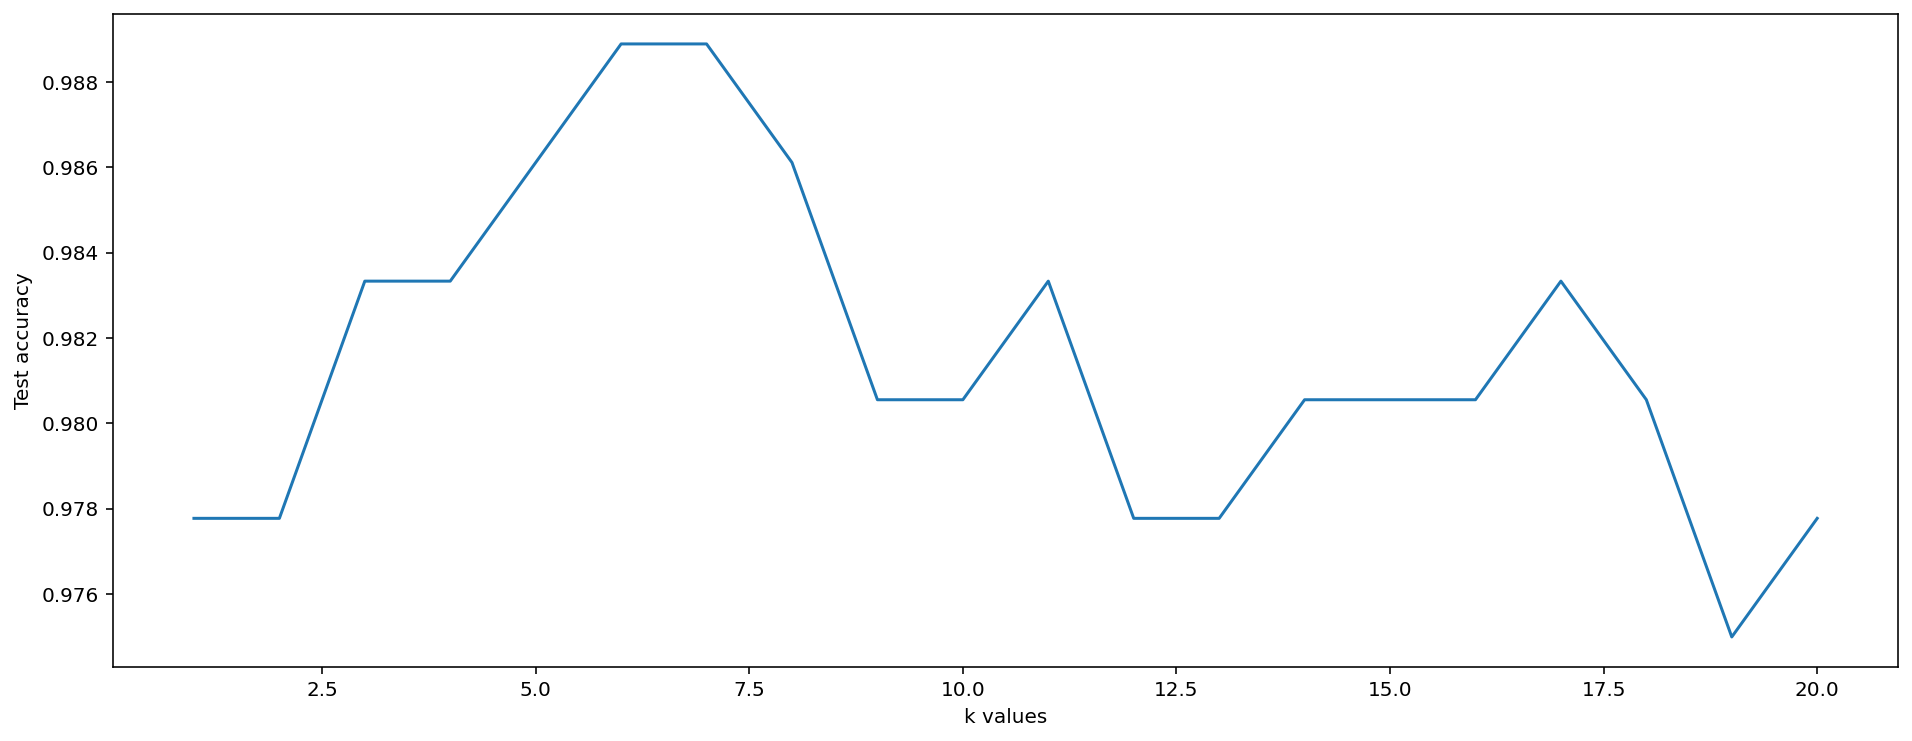

In [566]:
accuracy = []
k_range = range(1, 21)

plt.figure(figsize=(16,6))
plt.xlabel('k values')
plt.ylabel('Test accuracy')

for k in k_range:
    model = CustomKNeighborsClassifier(n_neighbors=k, weights='distance')
    model.fit(X_train, y_train)
    acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    accuracy.append(acc)

sns.lineplot(x=k_range, y=accuracy);

> While increasing k value test accuracy will be raising, but afte certain threshold (`7`) the accuracy start reducing since there will too much points in the area and results from different classes will be intersecting. 

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


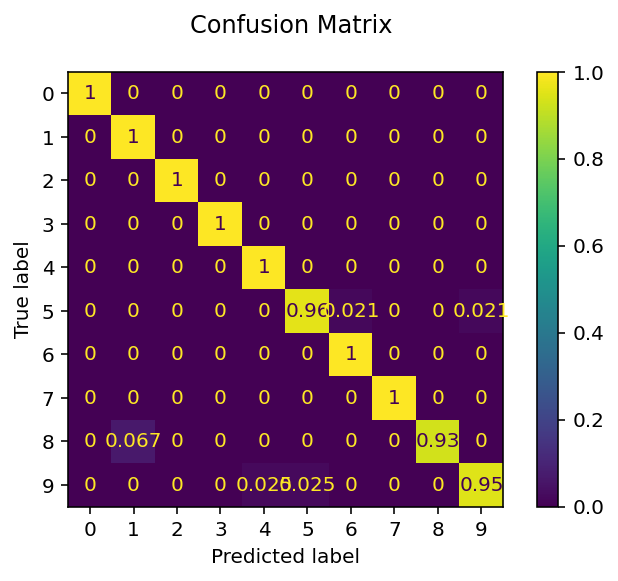

uniform weights resulted in 0.9833333333333333 test accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


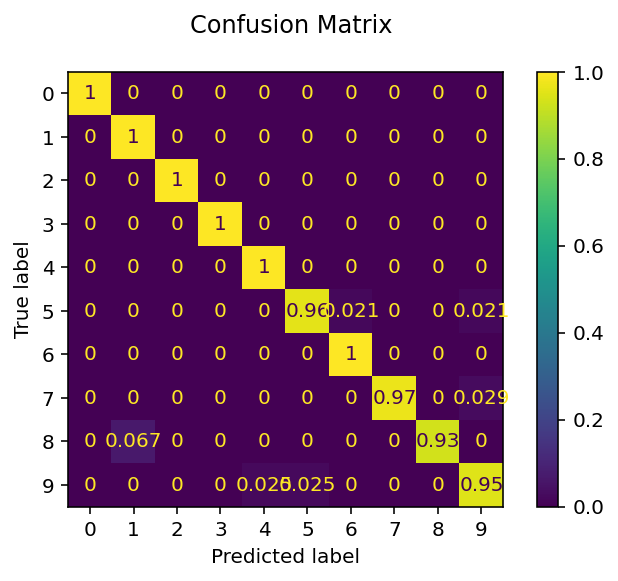

distance weights resulted in 0.9805555555555555 test accuracy


In [567]:
for weights in ['uniform', 'distance']:
    model = CustomKNeighborsClassifier(n_neighbors=10, weights=weights)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(f"{weights} weights resulted in {test_acc} test accuracy")

> For our case there is almost no difference when applying `'uniform'` or `'distance'` weights, but with `'distance'` we might see overfitting dur to the fact that the model will rely heavily on a choose of test data and the positioning of test data, not just areas, while `'uniform'` will provide us with behavior where each point in area will be of same weight. 

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

In [568]:
distances = ["euclidean", "manhattan", "chebyshev"]
# "minkowski", "wminkowski","seuclidean", "mahalanobis"]
for distance_function in distances:
    model = KNeighborsClassifier(n_neighbors=5, weights="uniform", metric=distance_function)
    model.fit(X_train, y_train)
    acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    print(f"{distance_function} function provide {acc:.2f} accuracy")

euclidean function provide 0.99 accuracy
manhattan function provide 0.98 accuracy
chebyshev function provide 0.98 accuracy


> Euclidean function seems to be performing quite well and better than the others. 

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

> Hamming distance if there will be categorical variables in our training set (not feature), for example if we introduce classes of numbers (handwritten/typed)

> Cosine distance/similarity if we want to tell user back the information on how is it numerically related to the data we have. 

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [569]:
PATH = "./data/"

In [570]:
# data = pd.read_csv("os.path.join(PATH, 'titanic', 'train.csv')").set_index('PassengerId')
data = pd.read_csv("https://www.dropbox.com/s/5bj8yta7f4vnvmj/train.csv?dl=1").set_index('PassengerId')

In [571]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [572]:
data.groupby(['Survived', 'Sex']).size()

Survived  Sex   
0         female    12660
          male      44566
1         female    31226
          male      11548
dtype: int64

> We can see that there are more survived women than men, but in the deceased cohort it's quite the opposit. So `Sex` is a good predictor for survival. 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

'Survived age median: 43.0'

'Deceased age median: 36.0'

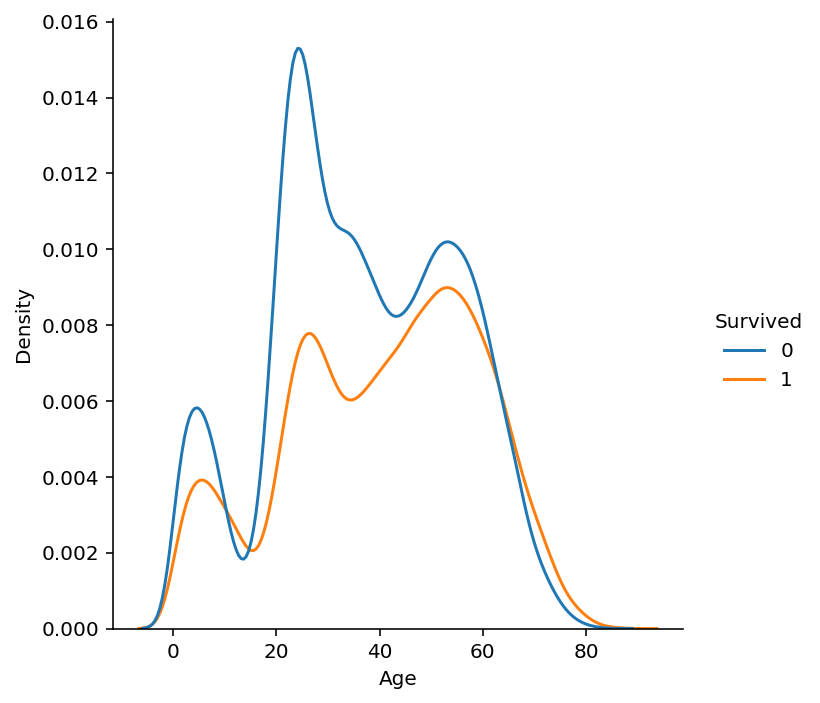

In [573]:
sns.displot(data, x='Age', hue='Survived', kind="kde")

display(f"Survived age median: {data[data.Survived==1].Age.median()}")
display(f"Deceased age median: {data[data.Survived==0].Age.median()}")

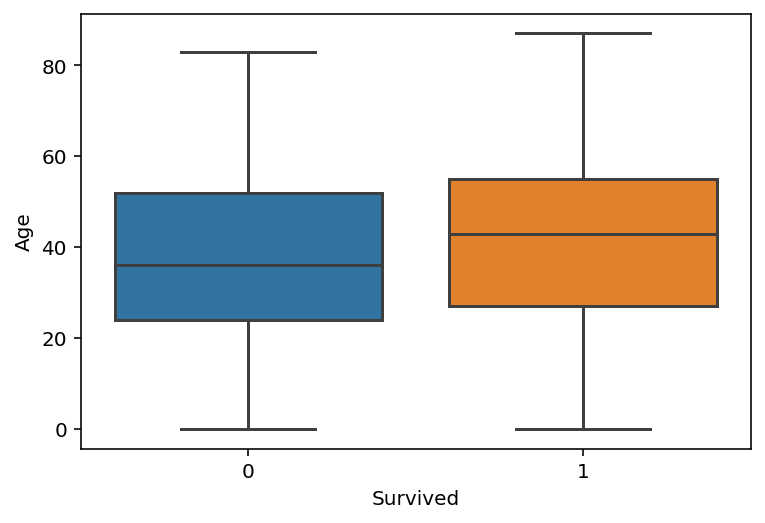

In [574]:
sns.boxplot(x="Survived", y="Age", data=data);

> There are a lot of deceased passengers aged from 20 till 30-40 so some portions of age is a good preddictor for the survavability. Median deceased age - 36, survived - 46.  

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

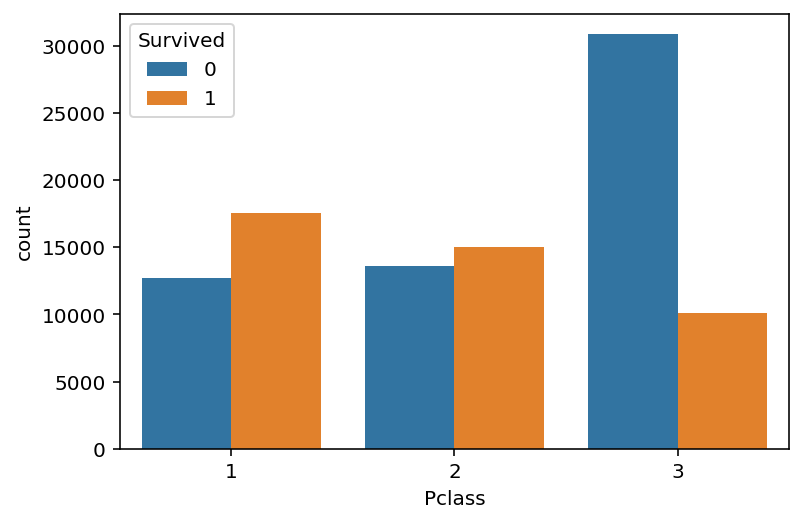

In [575]:
sns.countplot(x="Pclass", data=data, hue='Survived');

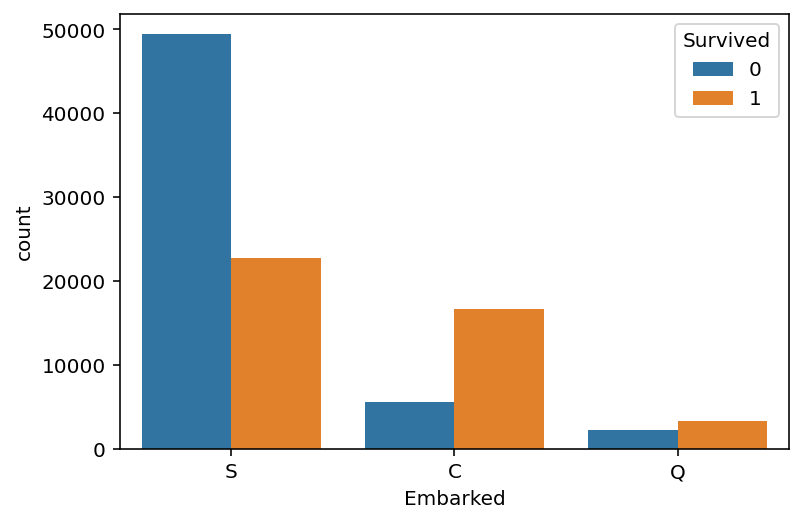

In [576]:
sns.countplot(x="Embarked", data=data, hue='Survived');

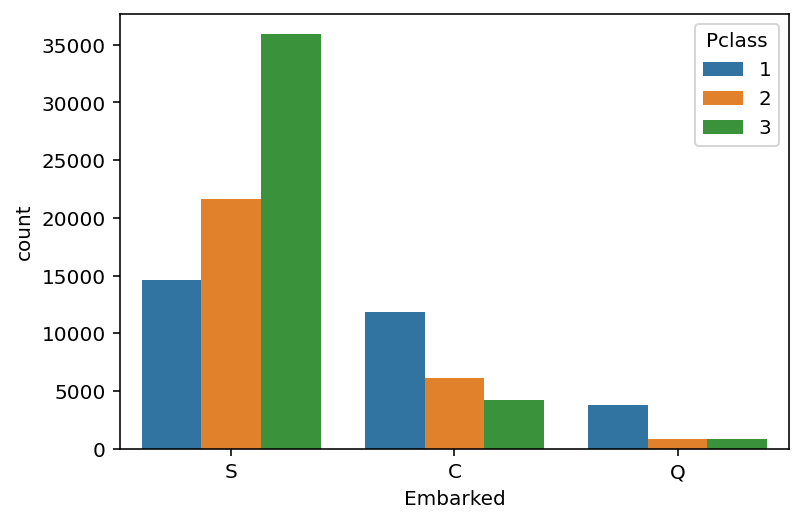

In [577]:
sns.countplot(x="Embarked", data=data, hue='Pclass');

> The deadliest class is the last one - the third, and most of the class was embarked on the `S` point (`Southampton`) therefore, this is the deadliest embarkation point. Class with best survavability is the first one. 

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [578]:
data.isna().mean() * 100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

> 1. Get `Age` from median of people goupped by `Pclass` and `Age` for better accuracy
> 2. Drop the `Ticket` column because it's almost impossible to extract any value.
> 3. Drop the `Cabin` column because it's hard to fullfill the value with such a huge percentage of missing values. 
> 4. Get `Fare` as median of fares grouped by `Pclass`
> 5. Fill `Embarked` with most common embarked - `S`. 
> 6. Additionally will drop `Name` because it's not giving us any values
> 7. Additionally will add `Family` with size of Family (`Parch` + `SibSp`)
> 8. Additionally change `Fare` to log scale, it will make distribution better

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [579]:
# Fix missing values
data.drop(columns=['Ticket', 'Cabin', 'Name'], inplace=True)

fill_data = {}

for pclass in data.Pclass.unique():
    for sex in data.Sex.unique():
        median_age = data[(data.Pclass == pclass) & (data.Sex == sex) & data.Age.notna()].Age.median()
        data.loc[(data.Pclass == pclass) & (data.Sex == sex) & data.Age.isna(), 'Age'] = median_age
        fill_data[(pclass, sex, 'Age')] = median_age

    median_fare = data[(data.Pclass == pclass) & data.Fare.notna()].Fare.median()
    data.loc[(data.Pclass == pclass) & data.Fare.isna(), 'Fare'] = median_age
    fill_data[(pclass, 'Fare')] = median_age

data.loc[data.Embarked.isna(), 'Embarked'] = 'S'

data['Family'] = data['Parch'] + data['SibSp'] + 1

data['Fare'] = data['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Sex       100000 non-null  object 
 3   Age       100000 non-null  float64
 4   SibSp     100000 non-null  int64  
 5   Parch     100000 non-null  int64  
 6   Fare      100000 non-null  float64
 7   Embarked  100000 non-null  object 
 8   Family    100000 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 9.6+ MB


In [580]:
from sklearn.preprocessing import LabelEncoder

# Get target and features
y = data['Survived']
X = data.loc[:, data.columns != 'Survived']

# Prepare pipeline for features
pipeline = lambda model: Pipeline([
    ('ohe', ColumnTransformer(
        [('Encode Embarked & Sex', OneHotEncoder(), ['Embarked', 'Sex'])],
        remainder='passthrough'
        )),
    ('sca', StandardScaler()),
    ('classifier', model)
])

In [581]:
knn = cross_validate(pipeline(KNeighborsClassifier()), X, y, cv=5, return_train_score=True, return_estimator=True, scoring='accuracy')
print(f"kNN accuracy {knn['test_score'].mean():.2f}")

kNN accuracy 0.74


In [582]:
from sklearn.linear_model import LogisticRegression

logreg = cross_validate(pipeline(LogisticRegression()), X, y, cv=5, return_train_score=True, return_estimator=True, scoring='accuracy')
print(f"LogReg accuracy {logreg['test_score'].mean():.3f}")

LogReg accuracy 0.766


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [583]:
np.random.seed(1)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': np.logspace(-4, 4, 4),
    'classifier__max_iter': [500, 2000, 3000],
}

grid = GridSearchCV(pipeline(LogisticRegression()), param_grid, cv=5, scoring='accuracy').fit(X, y)

tuned_model = grid.best_estimator_
print(f"Accuracy {grid.best_score_:.3f}")

Accuracy 0.767


In [584]:
# Load, prepare data, predict 
submission = pd.read_csv("https://www.dropbox.com/s/8s1azq4mz4xhqrk/test.csv?dl=1").set_index('PassengerId')
submission.drop(columns=['Ticket', 'Cabin', 'Name'], inplace=True)

for pclass in submission.Pclass.unique():
    for sex in submission.Sex.unique():
        median_age = fill_data[(pclass, sex, 'Age')]
        submission.loc[(submission.Pclass == pclass) & (submission.Sex == sex) & submission.Age.isna(), 'Age'] = median_age

    median_fare = fill_data[(pclass, 'Fare')]
    submission.loc[(submission.Pclass == pclass) & submission.Fare.isna(), 'Fare'] = median_age

submission.loc[submission.Embarked.isna(), 'Embarked'] = 'S'

submission['Family'] = submission['Parch'] + submission['SibSp'] + 1
submission['Fare'] = submission['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

submission['Survived'] = tuned_model.predict(submission)
submission['Survived'].to_csv('my_submission.csv')

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

**Public score 0.78755**

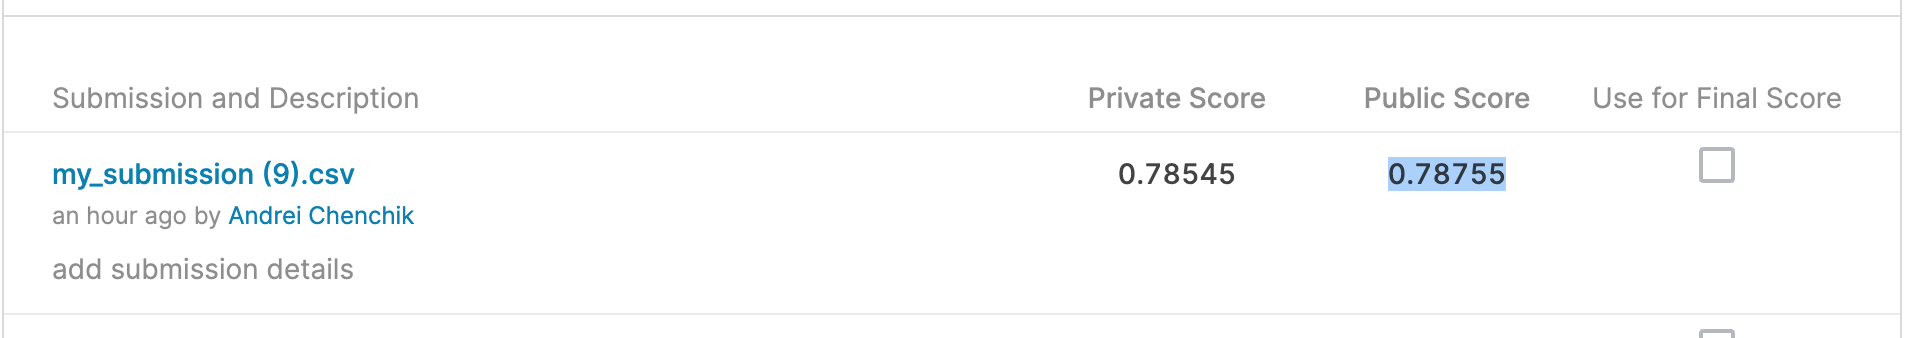